# Лабораторна робота .  K-means

Для вимірювання якості кластеризації існує декілька зовнішніх та внутрішніх метрик якості. Зовнішні використовують інформацію про справжнє розбиття на кластери, тоді як внутрішні метрики не використовують жодної зовнішньої інформації, і оцінюють якість кластеризації, ґрунтуючись лише на наборі даних, що кластеризуються. Оптимальне число кластерів зазвичай визначають із використанням внутрішніх метрик.
Найчастіше використовують метрики Adjusted Rand Index (ARI) та Adjusted Mutual Information (AMI), реалізовані, наприклад,
sklearn.metrics

Для того, щоб скористатися метриками, потрібно завантажити з пакету sklearn.metrics


А далі як параметр методів передати реальні мітки класу, і ті мітки, що їх простовив алгоритм.

Для ARI: metrics.adjusted_rand_score (справжні мітки, передбачені мітки dataTrainY).

Для AMI аналогічні параметри, тільки метод - metrics.adjusted_mutual_info_score.

## Завдання
1. Завантажте вибірку https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits і масштабуйте ознаки за допомогою scale із sklearn.preprocessing
2. Реалізуйте KMeans без використання готового рішення
3. Створіть KMeans з пакета sklearn.cluster, де в якості параметрів передайте init='k-means++', n_clusters=кількість унікальних значень з пункту 2, n_init=10, а як дані масштабовані ознаки.
4. Порахуйте такі метрики: ARI (Adjusted Rand Index) і AMI (Adjusted Mutual Information), а також час роботи алгоритму.
5. Аналогічно виконайте для моделі KMeans, де параметр init='random'
6. Порівняйте три підходи за часом та різними метриками. Зробіть висновки та обґрунтуйте їх.
9. Для наочності відобразіть дані на 2D площині, так само відобразіть центри кожного кластера та межі кожного кластера, використовуючи будь-яку з двох моделей.

In [9]:
import numpy as np
import time
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist

In [2]:
digits = load_digits()
X = scale(digits.data)
y = digits.target
n_clusters = len(np.unique(y))

In [3]:
class CustomKMeans:
    def __init__(self, n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-4, inertia_tol=1e-4, random_state=None, metric='euclidean'):
        """
        n_clusters: кількість кластерів
        init: метод ініціалізації ('random' або 'k-means++')
        n_init: кількість запусків з різними ініціалізаціями
        max_iter: максимальна кількість ітерацій
        tol: поріг для перевірки збіжності (зміна центроїдів)
        inertia_tol: поріг для перевірки збіжності (зміна інерції)
        random_state: фіксація випадковості
        metric: метрика відстані для cdist
        """
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.inertia_tol = inertia_tol
        self.random_state = random_state
        self.metric = metric

        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None

    def _init_centroids(self, X, rng):
        """Ініціалізація центроїдів з використанням локального генератора."""
        n_samples = X.shape[0]
        if self.init == 'k-means++':
            centroids = []
            idx = rng.choice(n_samples)
            centroids.append(X[idx])
            distances = np.full(n_samples, np.inf)
            for _ in range(1, self.n_clusters):
                distances = np.minimum(distances, cdist(X, [centroids[-1]], metric=self.metric).flatten())
                probs = distances ** 2 / np.sum(distances ** 2)
                next_idx = rng.choice(n_samples, p=probs)
                centroids.append(X[next_idx])
            return np.array(centroids)
        elif self.init == 'random':
            idx = rng.choice(n_samples, self.n_clusters, replace=False)
            return X[idx]
        else:
            raise ValueError("init must be 'random' or 'k-means++'")

    def fit(self, X):
        """Виконання кластеризації."""
        # Валідація вхідних даних
        if not isinstance(X, np.ndarray):
            X = np.asarray(X)
        if np.any(np.isnan(X)):
            raise ValueError("Input data contains NaN values")
        if X.shape[0] < self.n_clusters:
            raise ValueError("Number of samples is less than number of clusters")

        # Ініціалізація локального генератора
        rng = np.random.default_rng(self.random_state)

        best_inertia = None
        best_centroids = None
        best_labels = None
        best_n_iter = 0

        for _ in range(self.n_init):
            centroids = self._init_centroids(X, rng)
            prev_inertia = None
            labels = None
            inertia = np.inf
            i = 0

            for i in range(self.max_iter):
                # Обчислення відстаней і призначення міток
                distances = cdist(X, centroids, metric=self.metric)
                labels = np.argmin(distances, axis=1)

                # Оновлення центроїдів
                new_centroids = np.zeros_like(centroids)
                for k in range(self.n_clusters):
                    if np.any(labels == k):
                        new_centroids[k] = X[labels == k].mean(axis=0)
                    else:
                        distances_to_centroids = cdist(X, centroids, metric=self.metric)
                        farthest_idx = np.argmax(np.min(distances_to_centroids, axis=1))
                        new_centroids[k] = X[farthest_idx]

                # Перевірка зміни центроїдів
                shift = np.linalg.norm(new_centroids - centroids)

                # Обчислення інерції для перевірки збіжності
                inertia = np.sum(distances[np.arange(len(labels)), labels] ** 2)

                centroids = new_centroids

                # Перевірка критеріїв зупинки
                if shift < self.tol or (prev_inertia is not None and abs(inertia - prev_inertia) < self.inertia_tol):
                    break

                prev_inertia = inertia

            # Оновлення найкращого результату
            if best_inertia is None or inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
                best_n_iter = i + 1

        # Фінальне обчислення інерції
        self.cluster_centers_ = best_centroids
        if best_labels is None:  # Обробка випадку, якщо жодна ітерація не виконалася
            distances = cdist(X, self.cluster_centers_, metric=self.metric)
            best_labels = np.argmin(distances, axis=1)
            best_inertia = np.sum(distances[np.arange(len(best_labels)), best_labels] ** 2)
            best_n_iter = 0

        self.labels_ = best_labels
        self.inertia_ = best_inertia
        self.n_iter_ = best_n_iter

        return self

    def predict(self, X):
        """Прогнозування міток для нових даних."""
        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted yet")
        if not isinstance(X, np.ndarray):
            X = np.asarray(X)
        distances = cdist(X, self.cluster_centers_, metric=self.metric)
        return np.argmin(distances, axis=1)

In [4]:
def evaluate_model(model, X, y, model_name):
    start_time = time.time()
    model.fit(X)
    end_time = time.time()

    ari = adjusted_rand_score(y, model.labels_)
    ami = adjusted_mutual_info_score(y, model.labels_)
    time_taken = end_time - start_time

    print(f"\n{model_name}:")
    print(f"ARI: {ari:.4f}")
    print(f"AMI: {ami:.4f}")
    print(f"Час виконання: {time_taken:.4f} секунд")

    return model.labels_, model.cluster_centers_

In [5]:
print("Оцінка моделей:")
custom_kmeans = CustomKMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
custom_labels, custom_centroids = evaluate_model(custom_kmeans, X, y, "Власний KMeans")

kmeans_plus = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
kmeans_plus_labels, kmeans_plus_centroids = evaluate_model(kmeans_plus, X, y, "KMeans++")

kmeans_random = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=42)
kmeans_random_labels, kmeans_random_centroids = evaluate_model(kmeans_random, X, y, "KMeans Random")


Оцінка моделей:

Власний KMeans:
ARI: 0.4623
AMI: 0.6165
Час виконання: 0.2772 секунд

KMeans++:
ARI: 0.5344
AMI: 0.6678
Час виконання: 0.2270 секунд

KMeans Random:
ARI: 0.5177
AMI: 0.6568
Час виконання: 0.0939 секунд


In [6]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
centroids_2d = pca.transform(kmeans_plus_centroids)

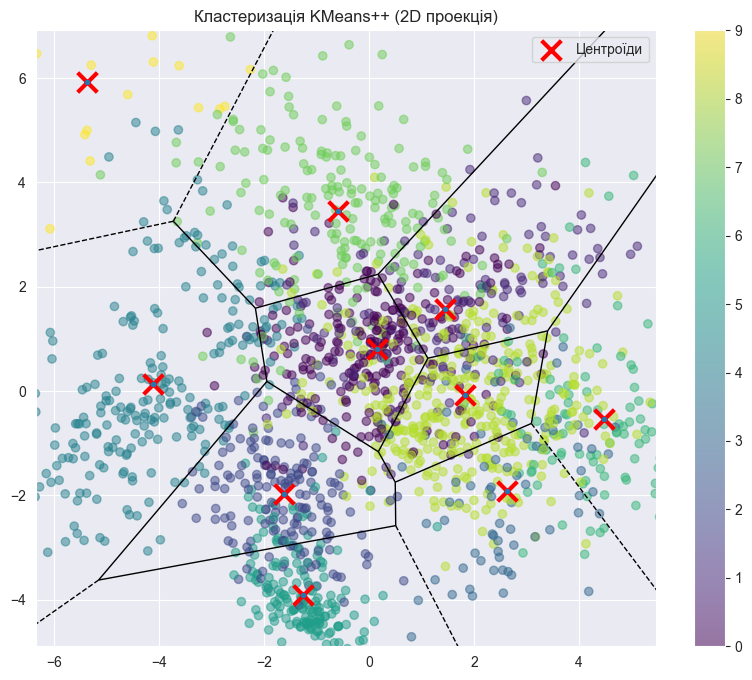

In [14]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_plus_labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='x', s=200, linewidths=3, label='Центроїди')

vor = Voronoi(centroids_2d)
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False)

plt.legend()
plt.title('Кластеризація KMeans++ (2D проекція)')
plt.colorbar(scatter)
plt.show()

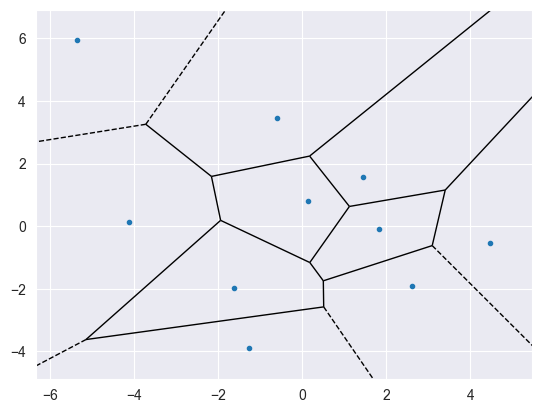

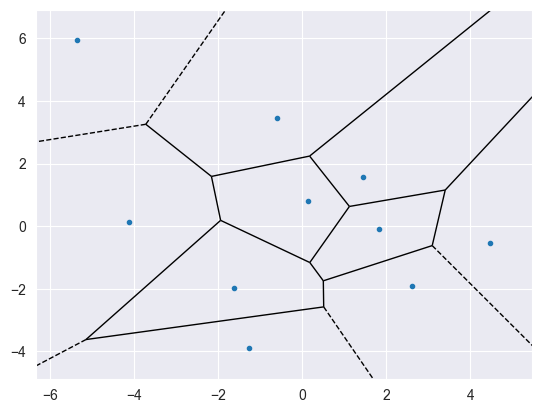

In [13]:
vor = Voronoi(centroids_2d)
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False)